## Radial Profiles

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
# First import some things we are gonna need
import treecorr
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=1.4*fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

### Import the LSBG and 2MPZ catalogs


#### LSBG

In [2]:
import pandas as pd

LSBG_df = pd.read_csv('LSBG_catalog.csv')

# Magnitudes
mag_g = LSBG_df['mag_gfm_g_corr'].values
mag_r = LSBG_df['mag_gfm_r_corr'].values
mag_i = LSBG_df['mag_gfm_i_corr'].values

# RA and DEC
RA = LSBG_df['ra_gfm'].values
DEC = LSBG_df['dec_gfm'].values

In [3]:
# Open MAP - we will need it
# ==========================================
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


#### 2MPZ

In [24]:
from astropy.io import fits
# Open and read the 2MPZ catalog
mpz_cat = fits.open('2MPZ.fits')
#mpz_cat[1].header.keys

# Convert to rad 
rad_to_deg = 180.0/np.pi
ra_mpz = rad_to_deg*mpz_cat[1].data['RA']
dec_mpz = rad_to_deg*mpz_cat[1].data['DEC']
z_mpz = mpz_cat[1].data['ZPHOTO']

print(len(ra_mpz))
for i in range(len(ra_mpz)):
    if (ra_mpz[i] > 150.):
        ra_mpz[i] = ra_mpz[i]-360.
        
# Keep only those in the box (-70,110)&(-70,10)
box = (ra_mpz>-70.0)&(ra_mpz<110.)&(dec_mpz>-70.0)&(dec_mpz<10.0)

ra_mpz = ra_mpz[box]
dec_mpz = dec_mpz[box]
z_mpz = z_mpz[box]

# ===============================================
# ===============================================
# keep those with z<0.10

ra_mpz = ra_mpz[z_mpz<0.1]
dec_mpz = dec_mpz[z_mpz<0.10]
z_mpz = z_mpz[z_mpz<0.10]


# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# ======================================================
# ======================================================
# Get the healpix indices of the mpz galaxies
HP_ind_mpz = hp.ang2pix(4096, ra_mpz, dec_mpz, lonlat=True)


# ===============================================
# Keep local mask
LOCAL_mask_mpz = DES_mask[HP_ind_mpz]

# Keep those with LOCAL_mask = 1
ra_mpz_in = ra_mpz[LOCAL_mask_mpz==1]
dec_mpz_in = dec_mpz[LOCAL_mask_mpz==1]
z_mpz_in = z_mpz[LOCAL_mask_mpz==1]

print(len(ra_mpz_in))

934175
90816


##### Define coordinates and redshifts/distances to the 9 most prominent peaks

I have decided to center everything to its best association.

In [33]:
# Right Ascension of the peaks

peaks_RA = [21.42, 55.0475, 17.501667, 21.374583, 10.027, 14.07625, 87.165, 73.709583, 42.40375]
#peaks_RA = [21.4200,55.0475,9.8882,17.6017,18.4758,54.6162,16.9299,21.3746,10.0270]

# Declination of the peaks
peaks_DEC = [-1.407222, -18.5875, -45.922778, 1.762778, -56.11666, -1.216667, -25.4584, -18.109167, -31.188611]
#peaks_DEC = [-1.4072,-18.5875,3.1385,-45.9228,-31.7519, -35.4483,-46.9165,1.7627,-56.1167]

#Distance to the peaks in Mpc
peaks_dists = [75.07, 23.41, 106.41, 72.32, 120.23, 190.58, 175.61, 147.75, 96.24]
#peaks_dists = [75.07,23.41,62.81,106.61,84.80,18.97,102.03,18.97,72.32,120.23]

In [34]:
len_sep = 16
seps = np.linspace(0.0,1.5,len_sep) # Array with separations 
dens_lsb = np.zeros([9,len_sep-1]) # Array of surface densities - LSB galaxies
dens_mpz = np.zeros([9,len_sep-1]) # Array of surface densities - 2MPZ galaxies


for i in range(9):
    # Coordinates of the i-th peak
    ra_pk = peaks_RA[i]
    dec_pk = peaks_DEC[i]
    # ===================================================
    # ===================================================
    # Select a box around the peak
    
    ra_up = ra_pk+3.0
    ra_low = ra_pk-3.0
    dec_up = dec_pk+3.0
    dec_low = dec_pk-3.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    box_2MPZ = (ra_mpz_in>ra_low)&(ra_mpz_in<ra_up)&(dec_mpz_in>dec_low)&(dec_mpz_in<dec_up)
    # =====================================================
    # =====================================================
    # Keep the LSB and 2MPZ galaxies inside the box
    ra_lsb_pk = RA[box_LSB]
    dec_lsb_pk = DEC[box_LSB]
    ra_mpz_pk = ra_mpz_in[box_2MPZ]
    dec_mpz_pk = dec_mpz_in[box_2MPZ]
    # =====================================================
    # =====================================================
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Create object for the hsb galaxies
    C_mpz_pk = SkyCoord(ra=ra_mpz_pk*u.degree, dec=dec_mpz_pk*u.degree, frame='icrs')
    # =====================================================
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    sep_mpz_pk = C_mpz_pk.separation(C_pk).deg # Separation between peak and 2mpz gals
    
    tot_area = np.pi*(1.5**2.0)
    mean_lsb = len(ra_lsb_pk[(sep_lsb_pk<1.5)])/tot_area # Mean number density of lsbgs
    mean_mpz = len(ra_mpz_pk[(sep_mpz_pk<1.5)])/tot_area # Mean number density of MPZs
    # =====================================================
    # =====================================================
    n_lsb = np.zeros(len_sep-1) # Array with number of LSBs
    n_mpz = np.zeros(len_sep-1) # Array with number of MPZ galaxies
    areas = np.zeros(len_sep-1) # Array with areas
    
    for j in range(len_sep-1):
        
        sep_min = seps[j] # minimum of the separation
        sep_max = seps[j+1] #maximum of the separation
        
        keep_lsb = ra_lsb_pk[(sep_lsb_pk>sep_min)&(sep_lsb_pk<=sep_max)]
        keep_mpz = ra_mpz_pk[(sep_mpz_pk>sep_min)&(sep_mpz_pk<=sep_max)]
        
        n_lsb[j] = len(keep_lsb)
        n_mpz[j] = len(keep_mpz) 
        areas[j] = np.pi*(sep_max**2.0 - sep_min**2.0)
        # ==================================================
        # ==================================================
    
    dens_lsb_loc = n_lsb/areas
    dens_mpz_loc = n_mpz/areas
    
    dens_lsb[i] = dens_lsb_loc/mean_lsb
    dens_mpz[i] = dens_mpz_loc/mean_mpz

#### Radial Profiles - Physical distance

In [35]:
len_sep = 16
seps_Mpc = np.linspace(0.0,1.5,len_sep) # Array with separations in Mpc
dens_lsb_phys = np.zeros([9,len_sep-1]) # Array of surface densities - LSB galaxies
dens_mpz_phys = np.zeros([9,len_sep-1]) # Arrat of surface densities - 2MPZ galaxies
errors_lsb = np.zeros([9,len_sep-1]) # Array to store errors in the calculation of LSBs
errors_mpz = np.zeros([9,len_sep-1]) # Array to store errors in the calculation of MPZs
# ================================================
# ================================================

for i in range(9):
    # Coordinates of the i-th peak
    ra_pk = peaks_RA[i]
    dec_pk = peaks_DEC[i]
    # ===================================================
    # ===================================================
    # Select a box around the peak
    
    ra_up = ra_pk+3*12.0
    ra_low = ra_pk-3*12.0
    dec_up = dec_pk+3*12.0
    dec_low = dec_pk-3*12.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    box_2MPZ = (ra_mpz_in>ra_low)&(ra_mpz_in<ra_up)&(dec_mpz_in>dec_low)&(dec_mpz_in<dec_up)
    # =====================================================
    # =====================================================
    # Keep the LSB and 2MPZ galaxies inside the box
    ra_lsb_pk = RA[box_LSB]
    dec_lsb_pk = DEC[box_LSB]
    ra_mpz_pk = ra_mpz_in[box_2MPZ]
    dec_mpz_pk = dec_mpz_in[box_2MPZ]
    # =====================================================
    # =====================================================
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Create object for the hsb galaxies
    C_mpz_pk = SkyCoord(ra=ra_mpz_pk*u.degree, dec=dec_mpz_pk*u.degree, frame='icrs')
    # =====================================================
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    sep_mpz_pk = C_mpz_pk.separation(C_pk).deg # Separation between peak and 2mpz gals
    
    
    # Here convert the array of physical separations to angular separations 
    seps_ang = rad_to_deg*(seps_Mpc/peaks_dists[i])
    
    max_angle = seps_ang[-1] # This is the maximum angular extend, in degrees, the corresponds to 1.5 Mpc
    tot_area = np.pi*(max_angle**2.0)
    numb_lsb = len(ra_lsb_pk[(sep_lsb_pk<max_angle)]) # Total number of LSBGs
    mean_lsb = numb_lsb/tot_area
    numb_mpz = len(ra_mpz_pk[(sep_mpz_pk<max_angle)]) # Total number of 2MPZ galaxies
    mean_mpz = numb_mpz/tot_area
    # =====================================================
    # =====================================================
    n_lsb = np.zeros(len_sep-1) # Array with number of LSBs
    n_mpz = np.zeros(len_sep-1) # Array with number of MPZ galaxies
    areas = np.zeros(len_sep-1) # Array with areas
    err_loc_lsb = np.zeros(len_sep-1)
    err_loc_mpz = np.zeros(len_sep-1)
    
    for j in range(len_sep-1):
        
        sep_min = seps_ang[j] # minimum of the separation - angle
        sep_max = seps_ang[j+1] #maximum of the separation - angle
        
        keep_lsb = ra_lsb_pk[(sep_lsb_pk>sep_min)&(sep_lsb_pk<=sep_max)]
        keep_mpz = ra_mpz_pk[(sep_mpz_pk>sep_min)&(sep_mpz_pk<=sep_max)]
        
        n_lsb[j] = len(keep_lsb)
        n_mpz[j] = len(keep_mpz) 
        areas[j] = np.pi*(sep_max**2.0 - sep_min**2.0)
        
        err_loc_lsb[j] = np.sqrt(1.0/(n_lsb[j]+1e-9) + 1.0/numb_lsb)
        err_loc_mpz[j] = np.sqrt(1.0/(n_mpz[j]+1e-9) + 1.0/numb_mpz)
        # ==================================================
        # ==================================================
    
    dens_lsb_loc = n_lsb/areas
    dens_mpz_loc = n_mpz/areas
    
    dens_lsb_phys[i] = dens_lsb_loc/mean_lsb
    dens_mpz_phys[i] = dens_mpz_loc/mean_mpz
    
    errors_lsb[i] = dens_lsb_phys[i]*err_loc_lsb
    errors_mpz[i] = dens_mpz_phys[i]*err_loc_mpz
    

#### Let's make a nice plot now!!

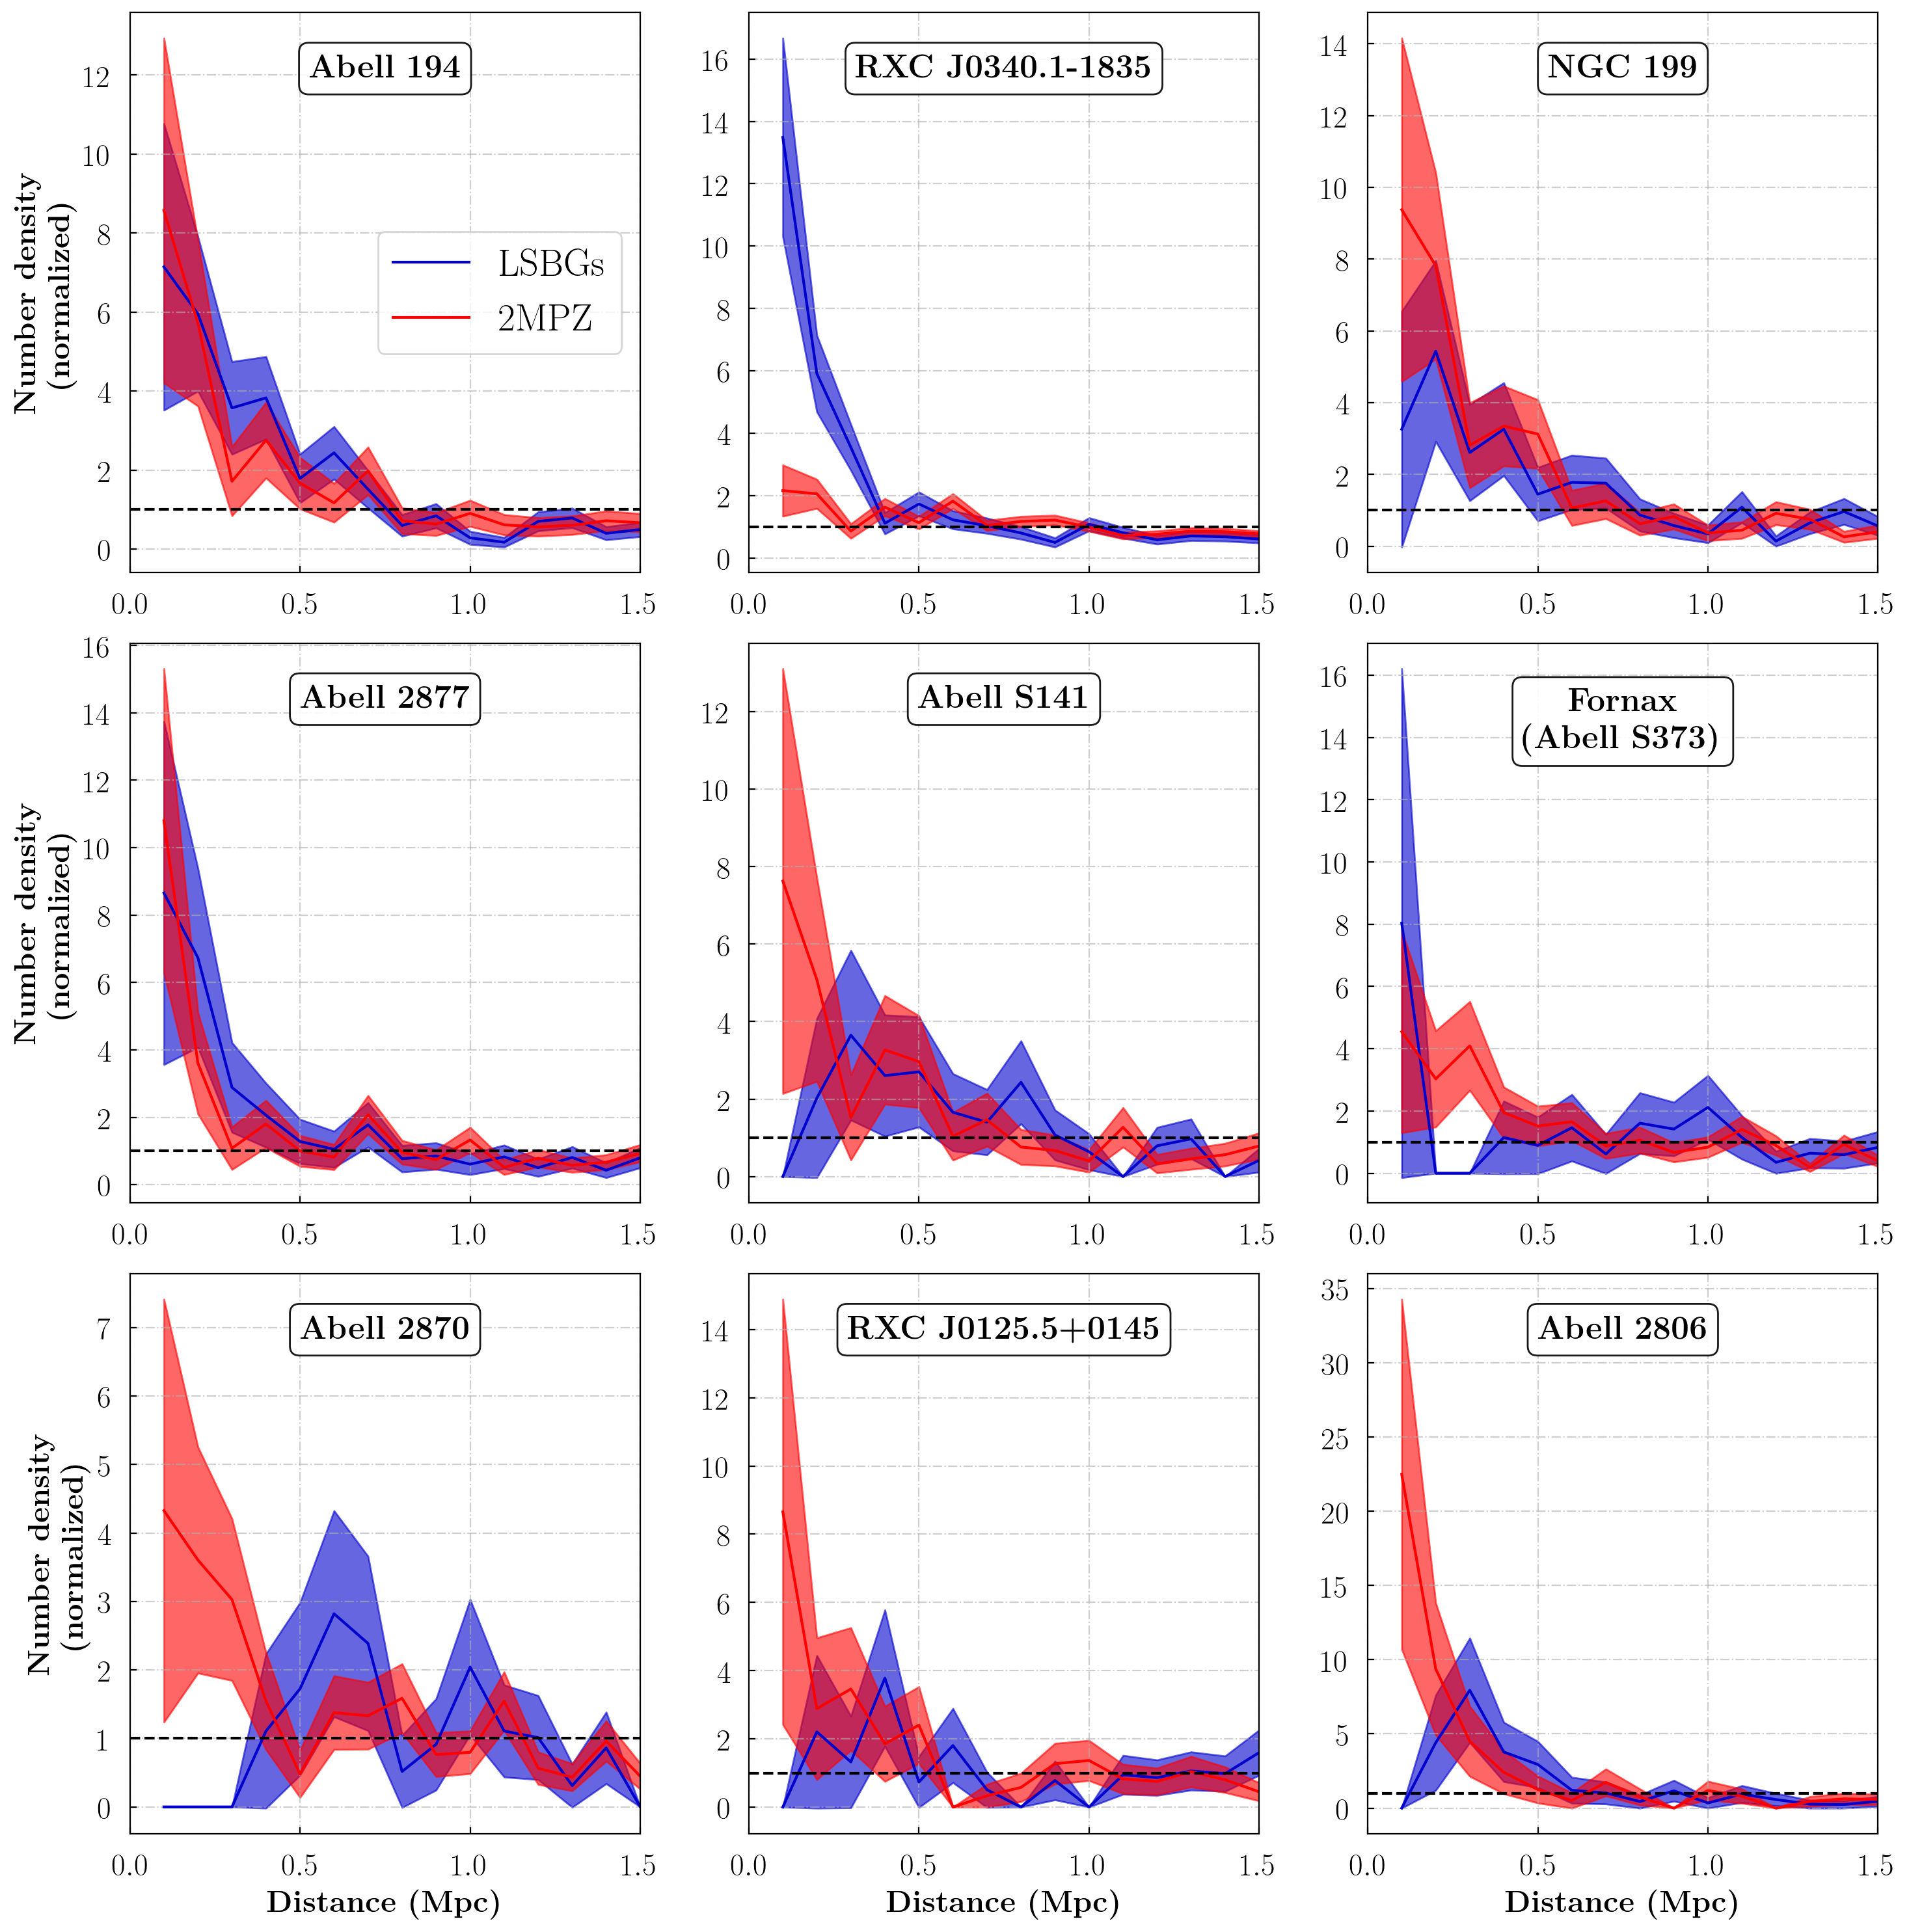

In [36]:
r = seps_Mpc[1:]
x_s = np.linspace(0.0,1.5,150)
y = np.ones(150)
Mpc_max = 1.5

props = dict(boxstyle='round', facecolor='white', alpha=0.9)


# =====================================================
# =====================================================
plot_pretty()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15.0,15.0))

plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)


# ==========================================================
# ==========================================================
# Plots
axes[0,0].plot(r,dens_lsb_phys[0],color='mediumblue', label='LSBGs')
axes[0,0].plot(r,dens_mpz_phys[0],color='r',label='2MPZ')
# Errors
axes[0,0].fill_between(r, dens_lsb_phys[0]-errors_lsb[0],dens_lsb_phys[0]+errors_lsb[0], color='mediumblue', alpha=0.6)
axes[0,0].fill_between(r, dens_mpz_phys[0]-errors_mpz[0],dens_mpz_phys[0]+errors_mpz[0], color='r', alpha=0.6)




axes[0,0].plot(x_s,y,color='k',ls='--')
axes[0,0].grid(ls='-.',alpha=0.6)

# Customize
axes[0,0].set_xlim(0.0,Mpc_max)

axes[0,0].legend(frameon=True, loc='center right', fontsize=21, columnspacing=0.1)
axes[0,0].text(0.5 ,0.9,r'\textbf{Abell 194}', horizontalalignment='center',
               verticalalignment='center', transform=axes[0,0].transAxes,bbox=props,fontsize=18)
axes[0,0].set_ylabel(r'\textbf{Number density}''\n' r'\textbf{(normalized)}',fontsize=17)
# ==========================================================
# ==========================================================
# Plots
axes[0,1].plot(r,dens_lsb_phys[1],color='mediumblue')
axes[0,1].plot(r,dens_mpz_phys[1],color='r')
# Errors
axes[0,1].fill_between(r, dens_lsb_phys[1]-errors_lsb[1],dens_lsb_phys[1]+errors_lsb[1], color='mediumblue', alpha=0.6)
axes[0,1].fill_between(r, dens_mpz_phys[1]-errors_mpz[1],dens_mpz_phys[1]+errors_mpz[1], color='r', alpha=0.6)


axes[0,1].plot(x_s,y,color='k',ls='--')
axes[0,1].grid(ls='-.',alpha=0.6)
# Customize
axes[0,1].set_xlim(0.0,Mpc_max)
axes[0,1].text(0.5 ,0.9,r'\textbf{RXC J0340.1-1835}', horizontalalignment='center',
               verticalalignment='center', transform=axes[0,1].transAxes,bbox=props,fontsize=18)

# ==========================================================
# ==========================================================
# Plots 
axes[0,2].plot(r,dens_lsb_phys[2],color='mediumblue')
axes[0,2].plot(r,dens_mpz_phys[2],color='r')
# Errors
axes[0,2].fill_between(r, dens_lsb_phys[2]-errors_lsb[2],dens_lsb_phys[2]+errors_lsb[2], color='mediumblue', alpha=0.6)
axes[0,2].fill_between(r, dens_mpz_phys[2]-errors_mpz[2],dens_mpz_phys[2]+errors_mpz[2], color='r', alpha=0.6)




axes[0,2].plot(x_s,y,color='k',ls='--')
axes[0,2].grid(ls='-.',alpha=0.6)

# Customize
axes[0,2].set_xlim(0.0,Mpc_max)
axes[0,2].text(0.5 ,0.9,r'\textbf{NGC 199}', horizontalalignment='center',
               verticalalignment='center', transform=axes[0,2].transAxes,bbox=props,fontsize=18)

# ==========================================================
# ==========================================================
# Plots
axes[1,0].plot(r,dens_lsb_phys[3],color='mediumblue')
axes[1,0].plot(r,dens_mpz_phys[3],color='r')
# Errors
axes[1,0].fill_between(r, dens_lsb_phys[3]-errors_lsb[3],dens_lsb_phys[3]+errors_lsb[3], color='mediumblue', alpha=0.6)
axes[1,0].fill_between(r, dens_mpz_phys[3]-errors_mpz[3],dens_mpz_phys[3]+errors_mpz[3], color='r', alpha=0.6)





axes[1,0].plot(x_s,y,color='k',ls='--')
axes[1,0].grid(ls='-.',alpha=0.6)


# Customize
axes[1,0].set_xlim(0.0,Mpc_max)
axes[1,0].text(0.5 ,0.9,r'\textbf{Abell 2877}', horizontalalignment='center',
               verticalalignment='center', transform=axes[1,0].transAxes,bbox=props,fontsize=18)
axes[1,0].set_ylabel(r'\textbf{Number density}''\n' r'\textbf{(normalized)}', fontsize=17)
# ==========================================================
# ==========================================================
# Plots
axes[1,1].plot(r,dens_lsb_phys[4],color='mediumblue')
axes[1,1].plot(r,dens_mpz_phys[4],color='r')
# Errors
axes[1,1].fill_between(r, dens_lsb_phys[4]-errors_lsb[4],dens_lsb_phys[4]+errors_lsb[4], color='mediumblue', alpha=0.6)
axes[1,1].fill_between(r, dens_mpz_phys[4]-errors_mpz[4],dens_mpz_phys[4]+errors_mpz[4], color='r', alpha=0.6)




axes[1,1].plot(x_s,y,color='k',ls='--')
axes[1,1].grid(ls='-.',alpha=0.6)

# Customize
axes[1,1].set_xlim(0.0,Mpc_max)
axes[1,1].text(0.5 ,0.9,r'\textbf{Abell S141}', horizontalalignment='center',
               verticalalignment='center', transform=axes[1,1].transAxes,bbox=props,fontsize=18)


# ==========================================================
# ==========================================================
# Plots
axes[1,2].plot(r,dens_lsb_phys[5],color='mediumblue')
axes[1,2].plot(r,dens_mpz_phys[5],color='r')
# Errors
axes[1,2].fill_between(r, dens_lsb_phys[5]-errors_lsb[5],dens_lsb_phys[5]+errors_lsb[5], color='mediumblue', alpha=0.6)
axes[1,2].fill_between(r, dens_mpz_phys[5]-errors_mpz[5],dens_mpz_phys[5]+errors_mpz[5], color='r', alpha=0.6)



axes[1,2].plot(x_s,y,color='k',ls='--')
axes[1,2].grid(ls='-.',alpha=0.6)

# Customize
axes[1,2].set_xlim(0.0,Mpc_max)
axes[1,2].text(0.5 ,0.86,r'\textbf{Fornax}''\n' r'\textbf{(Abell S373)}', horizontalalignment='center',
               verticalalignment='center', transform=axes[1,2].transAxes,bbox=props,fontsize=18)


# ==========================================================
# ==========================================================
# Plots
axes[2,0].plot(r,dens_lsb_phys[6],color='mediumblue')
axes[2,0].plot(r,dens_mpz_phys[6],color='r')
# Errors
axes[2,0].fill_between(r, dens_lsb_phys[6]-errors_lsb[6],dens_lsb_phys[6]+errors_lsb[6], color='mediumblue', alpha=0.6)
axes[2,0].fill_between(r, dens_mpz_phys[6]-errors_mpz[6],dens_mpz_phys[6]+errors_mpz[6], color='r', alpha=0.6)


axes[2,0].plot(x_s,y,color='k',ls='--')
axes[2,0].grid(ls='-.',alpha=0.6)

# Customize
axes[2,0].set_xlim(0.0,Mpc_max)
axes[2,0].text(0.5 ,0.9,r'\textbf{Abell 2870}', horizontalalignment='center',
               verticalalignment='center', transform=axes[2,0].transAxes,bbox=props,fontsize=18)

axes[2,0].set_xlabel(r'\textbf{Distance (Mpc)}', fontsize = 17)
axes[2,0].set_ylabel(r'\textbf{Number density}''\n' r'\textbf{(normalized)}', fontsize=17)
# ==========================================================
# ==========================================================
# Plots
axes[2,1].plot(r,dens_lsb_phys[7],color='mediumblue')
axes[2,1].plot(r,dens_mpz_phys[7],color='r')
# Errors
axes[2,1].fill_between(r, dens_lsb_phys[7]-errors_lsb[7],dens_lsb_phys[7]+errors_lsb[7], color='mediumblue', alpha=0.6)
axes[2,1].fill_between(r, dens_mpz_phys[7]-errors_mpz[7],dens_mpz_phys[7]+errors_mpz[7], color='r', alpha=0.6)



axes[2,1].plot(x_s,y,color='k',ls='--')
axes[2,1].grid(ls='-.',alpha=0.6)

# Customize
axes[2,1].set_xlim(0.0,Mpc_max)
axes[2,1].text(0.5 ,0.9,r'\textbf{RXC J0125.5+0145}', horizontalalignment='center',
               verticalalignment='center', transform=axes[2,1].transAxes,bbox=props,fontsize=18)

axes[2,1].set_xlabel(r'\textbf{Distance (Mpc)}', fontsize = 17)
# ==========================================================
# ==========================================================
# Plots
axes[2,2].plot(r,dens_lsb_phys[8],color='mediumblue')
axes[2,2].plot(r,dens_mpz_phys[8],color='r')
# Errors
axes[2,2].fill_between(r, dens_lsb_phys[8]-errors_lsb[8],dens_lsb_phys[8]+errors_lsb[8], color='mediumblue', alpha=0.6)
axes[2,2].fill_between(r, dens_mpz_phys[8]-errors_mpz[8],dens_mpz_phys[8]+errors_mpz[8], color='r', alpha=0.6)



axes[2,2].plot(x_s,y,color='k',ls='--')
axes[2,2].grid(ls='-.',alpha=0.6)
# Customize
axes[2,2].set_xlim(0.0,Mpc_max)
axes[2,2].text(0.5 ,0.9,r'\textbf{Abell 2806}', horizontalalignment='center',
               verticalalignment='center', transform=axes[2,2].transAxes,bbox=props,fontsize=18)


axes[2,2].set_xlabel(r'\textbf{Distance (Mpc)}', fontsize = 17)

plt.tight_layout()
plt.savefig('Rad_profiles.pdf')
plt.show()

### K-S test

Perform a K-S test for all the peaks

In [29]:
peaks_df = pd.read_csv('peaks_associations.csv')

ra_peak = peaks_df['ra_assoc'].values #ra
dec_peak = peaks_df['dec_assoc'].values #dec
dist_peak = peaks_df['dist_assoc'].values #dist

ra_peak = ra_peak[:10]
dec_peak = dec_peak[:10]
dist_peak = dist_peak[:10]


len_sep = 70
seps_Mpc = np.linspace(0.0,1.5,len_sep) # Array with separations in Mpc
dens_lsb_phys = np.zeros([10,len_sep-1]) # Array of surface densities - LSB galaxies
dens_mpz_phys = np.zeros([10,len_sep-1]) # Arrat of surface densities - 2MPZ galaxies
errors_lsb = np.zeros([10,len_sep-1]) # Array to store errors in the calculation of LSBs
errors_mpz = np.zeros([10,len_sep-1]) # Array to store errors in the calculation of MPZs
# ================================================
# ================================================

for i in range(10):
    #print(i)
    # Coordinates of the i-th peak
    ra_pk = ra_peak[i]
    dec_pk = dec_peak[i]
    # ===================================================
    # ===================================================
    # Select a box around the peak
    
    ra_up = ra_pk+12.0
    ra_low = ra_pk-12.0
    dec_up = dec_pk+12.0
    dec_low = dec_pk-12.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    box_2MPZ = (ra_mpz_in>ra_low)&(ra_mpz_in<ra_up)&(dec_mpz_in>dec_low)&(dec_mpz_in<dec_up)
    # =====================================================
    # =====================================================
    # Keep the LSB and 2MPZ galaxies inside the box
    ra_lsb_pk = RA[box_LSB]
    dec_lsb_pk = DEC[box_LSB]
    ra_mpz_pk = ra_mpz_in[box_2MPZ]
    dec_mpz_pk = dec_mpz_in[box_2MPZ]
    # =====================================================
    # =====================================================
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Create object for the hsb galaxies
    C_mpz_pk = SkyCoord(ra=ra_mpz_pk*u.degree, dec=dec_mpz_pk*u.degree, frame='icrs')
    # =====================================================
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    sep_mpz_pk = C_mpz_pk.separation(C_pk).deg # Separation between peak and 2mpz gals
    
    
    # Here convert the array of physical separations to angular separations 
    seps_ang = rad_to_deg*(seps_Mpc/dist_peak[i])
    
    max_angle = seps_ang[-1] # This is the maximum angular extend, in degrees, the corresponds to 1.5 Mpc
    tot_area = np.pi*(max_angle**2.0)
    numb_lsb = len(ra_lsb_pk[(sep_lsb_pk<max_angle)]) # Total number of LSBGs
    mean_lsb = numb_lsb/tot_area
    numb_mpz = len(ra_mpz_pk[(sep_mpz_pk<max_angle)]) # Total number of 2MPZ galaxies
    mean_mpz = numb_mpz/tot_area
    # =====================================================
    # =====================================================
    n_lsb = np.zeros(len_sep-1) # Array with number of LSBs
    n_mpz = np.zeros(len_sep-1) # Array with number of MPZ galaxies
    areas = np.zeros(len_sep-1) # Array with areas
    
    #err_loc_lsb = np.zeros(len_sep-1)
    #err_loc_mpz = np.zeros(len_sep-1)
    
    for j in range(len_sep-1):
        
        sep_min = seps_ang[j] # minimum of the separation - angle
        sep_max = seps_ang[j+1] #maximum of the separation - angle
        
        keep_lsb = ra_lsb_pk[(sep_lsb_pk>sep_min)&(sep_lsb_pk<=sep_max)]
        keep_mpz = ra_mpz_pk[(sep_mpz_pk>sep_min)&(sep_mpz_pk<=sep_max)]
        
        n_lsb[j] = len(keep_lsb)
        n_mpz[j] = len(keep_mpz) 
        areas[j] = np.pi*(sep_max**2.0 - sep_min**2.0)
        
        #err_loc_lsb[j] = np.sqrt(1.0/(n_lsb[j]+1e-9) + 1.0/numb_lsb)
        #err_loc_mpz[j] = np.sqrt(1.0/(n_mpz[j]+1e-9) + 1.0/numb_mpz)
        # ==================================================
        # ==================================================

    dens_lsb_loc = n_lsb/areas
    dens_mpz_loc = n_mpz/areas
    
    dens_lsb_phys[i] = dens_lsb_loc/mean_lsb
    dens_mpz_phys[i] = dens_mpz_loc/mean_mpz
    
    #errors_lsb[i] = dens_lsb_phys[i]*err_loc_lsb
    #errors_mpz[i] = dens_mpz_phys[i]*err_loc_mpz
    

In [10]:
from scipy import stats

ks_val = np.zeros(10)
p_val = np.zeros(10)
for i in range(10):
    d_1 = dens_lsb_phys[i]
    d_2 = dens_mpz_phys[i]
    d_1_norm = d_1/np.sum(d_1)
    d_2_norm = d_2/np.sum(d_2)
    
    ks, p = stats.ks_2samp(d_1_norm,d_2_norm)
    
    ks_val[i] = ks
    p_val[i] = p

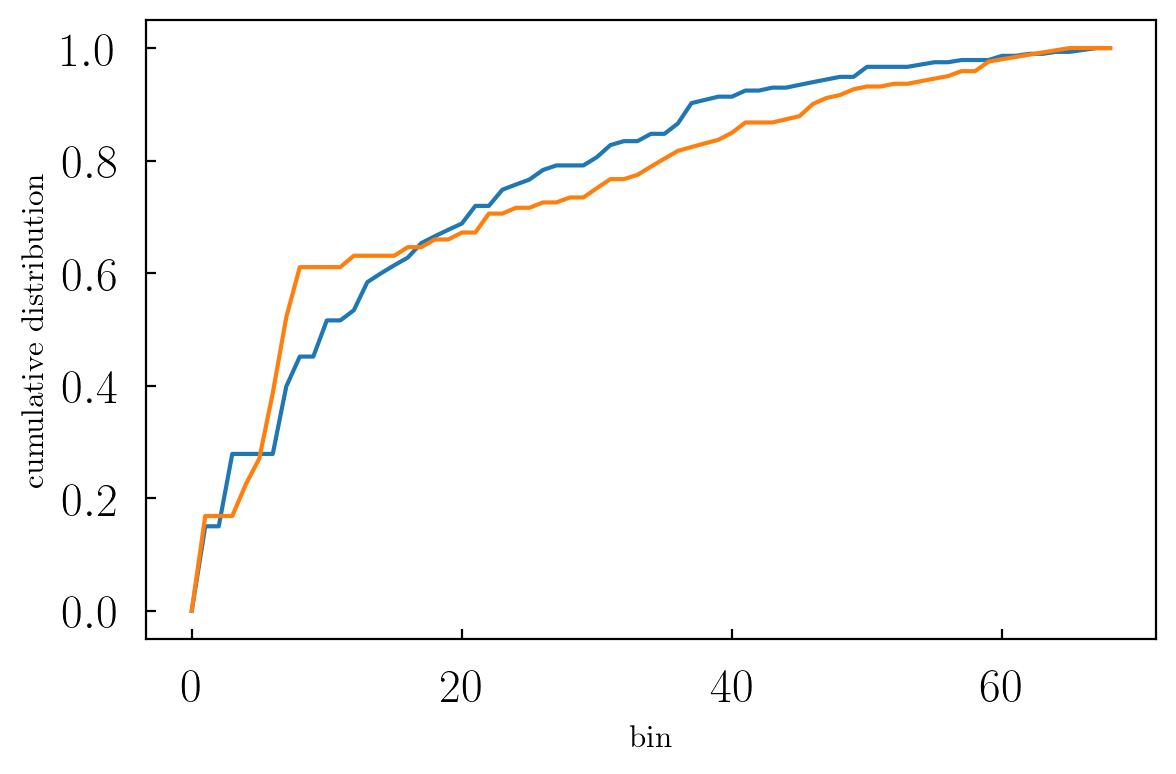

In [11]:
d_1 = dens_lsb_phys[4]
d_2 = dens_mpz_phys[4]
d_1_norm = d_1/np.sum(d_1)
d_2_norm = d_2/np.sum(d_2)

CDF_1 = np.zeros(len(d_1))
CDF_2 = np.zeros(len(d_1))

for i in range(len(d_1)):
    CDF_1[i] = np.sum(d_1_norm[:i+1])
    CDF_2[i] = np.sum(d_2_norm[:i+1])


plt.plot(CDF_1)
plt.plot(CDF_2)
plt.xlabel('bin')
plt.ylabel('cumulative distribution')
plt.tight_layout()
plt.savefig('cumulative.png')

### Spatial distribution of 2MPZ

In [37]:
import skymap as smap
from skymap import DESSkymap

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


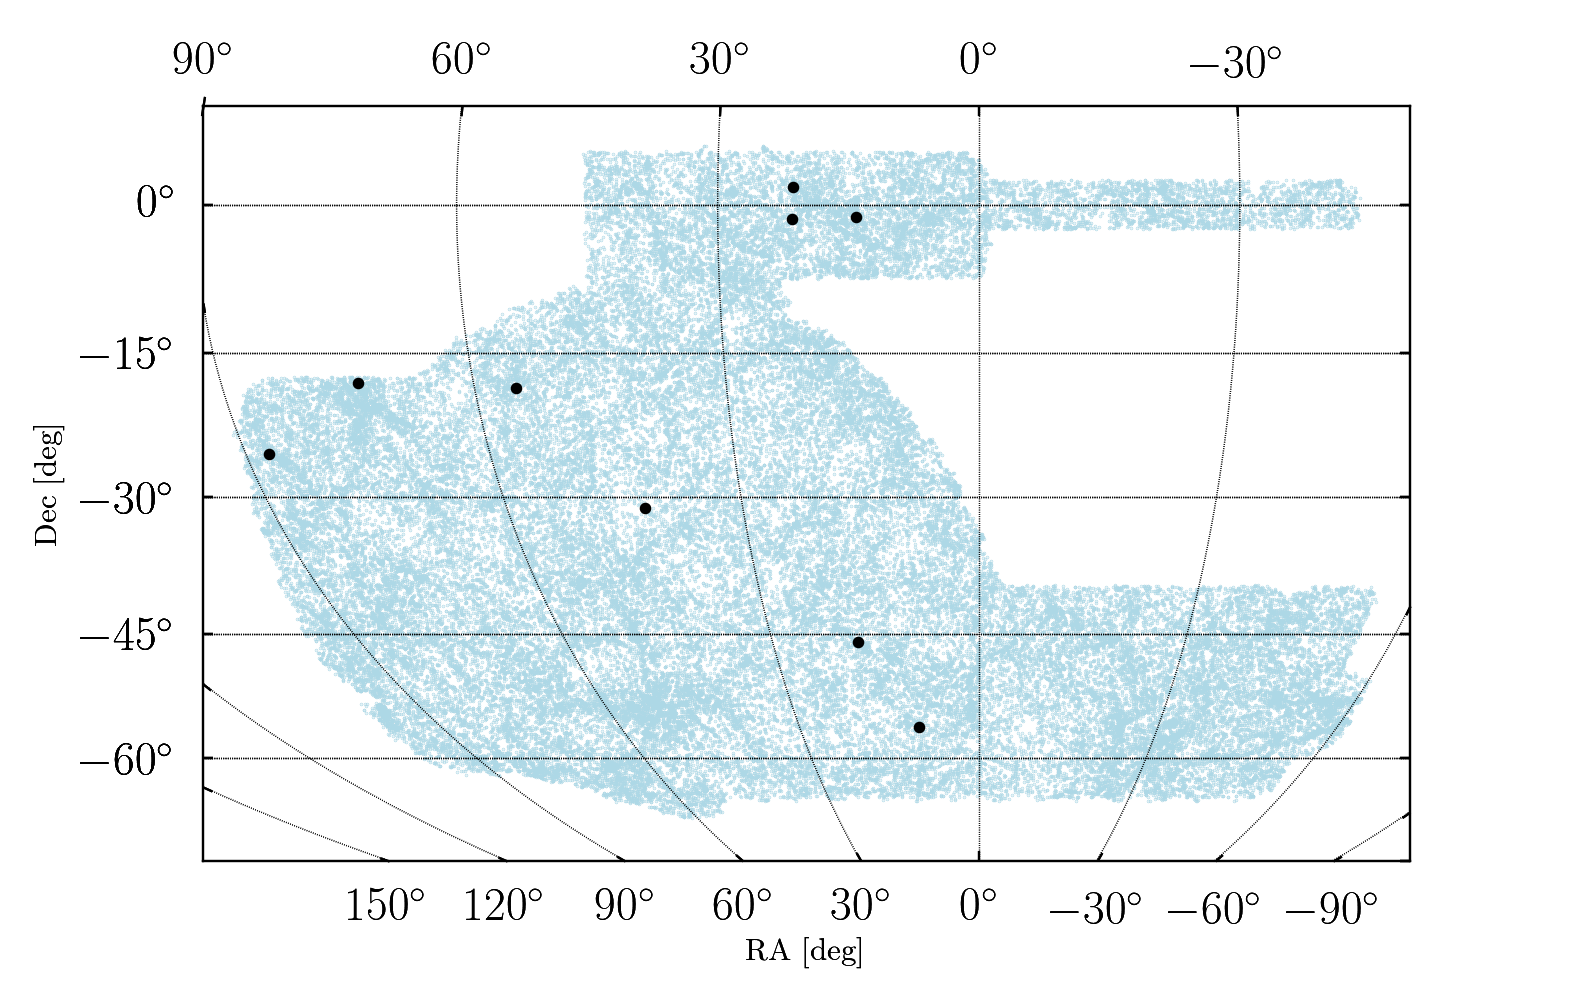

In [43]:
plt.figure(figsize = (8.0,5.0))

smap = DESSkymap()

smap.scatter(ra_mpz_in, dec_mpz_in, c='lightblue',rasterized=True, s=0.05,latlon=True)
#smap.draw_des(color='k',linewidth=0.7,label='DES footprint')

smap.scatter(peaks_RA,peaks_DEC,c='k',s=10,latlon=True)

plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

#plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig('Footprint.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
#plt.savefig('Reds.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


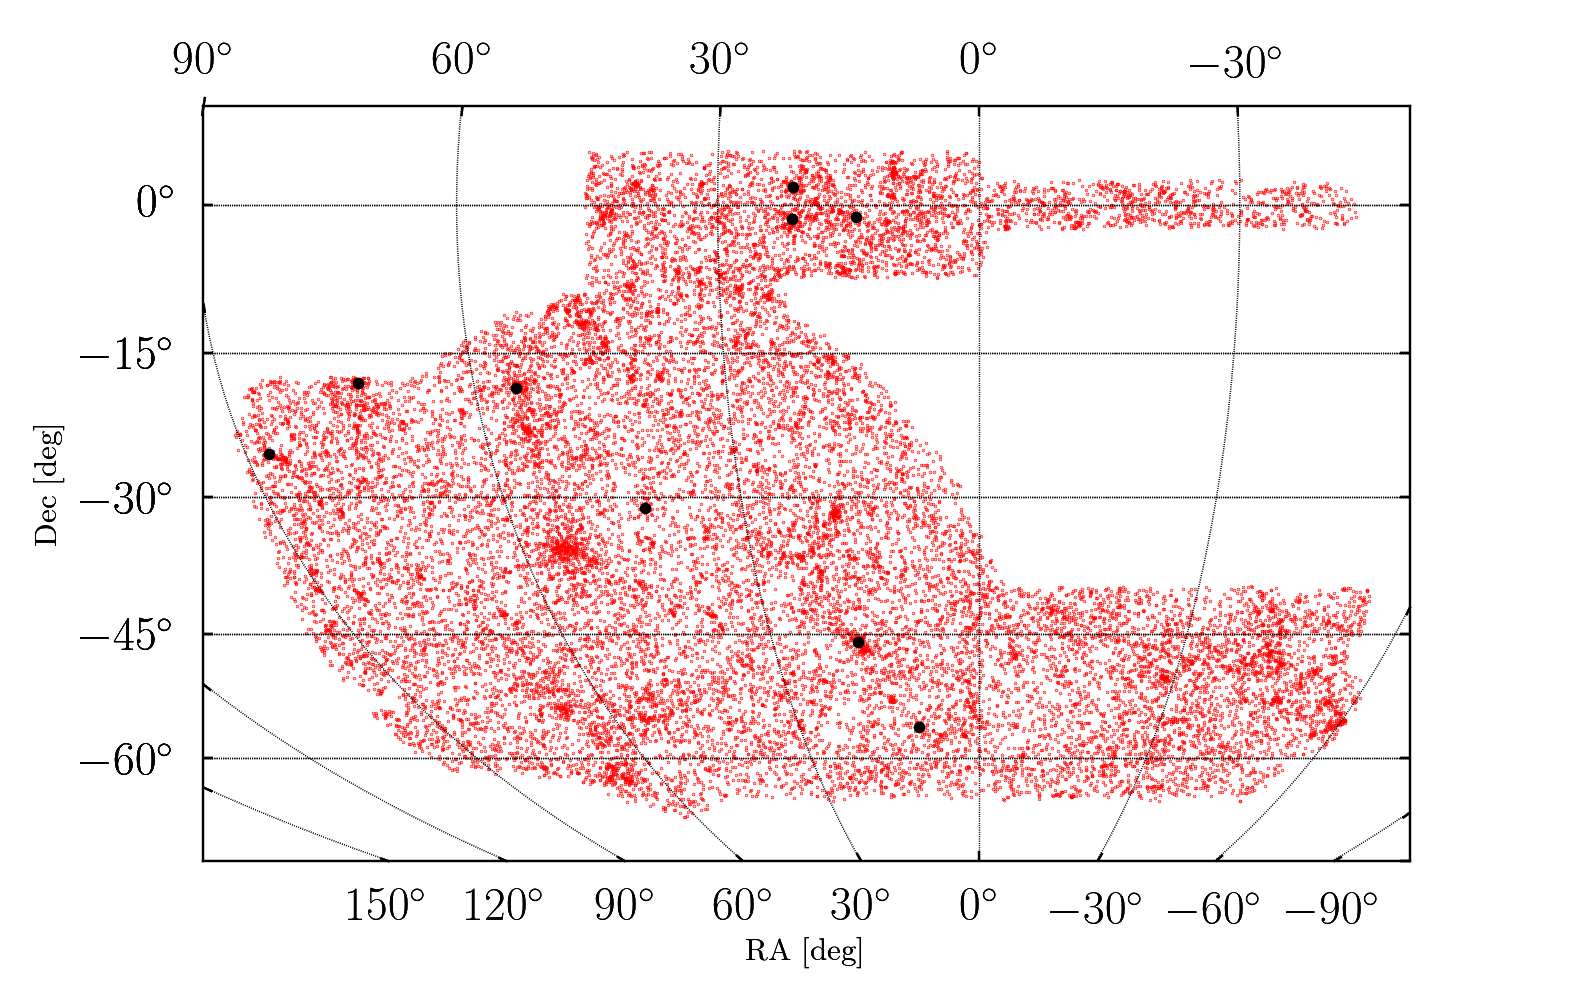

In [46]:
plt.figure(figsize = (8.0,5.0))

smap = DESSkymap()

smap.scatter(RA, DEC, c='red',rasterized=True, s=0.05,latlon=True)
#smap.draw_des(color='k',linewidth=0.7,label='DES footprint')

smap.scatter(peaks_RA,peaks_DEC,c='k',s=10,latlon=True)

plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

#plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig('Footprint.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
#plt.savefig('Reds.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

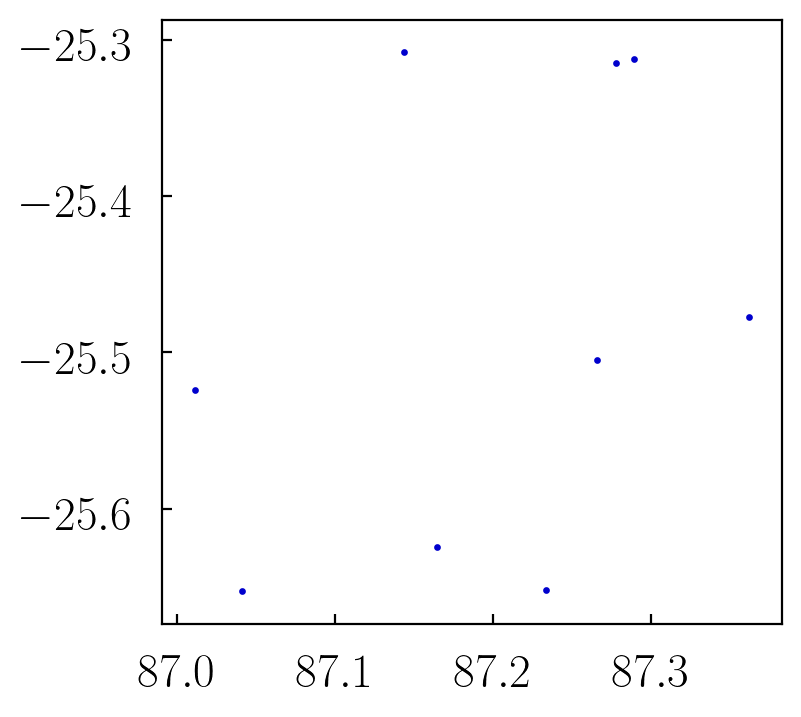

In [67]:
ra_peak = 87.165
dec_peak = -25.4584
delta = 0.2

box = (RA>(ra_peak-delta))&(RA<(ra_peak+delta))&(DEC>(dec_peak-delta))&(DEC<(dec_peak+delta))

plt.figure(figsize = (4.0,4.0))
plt.scatter(RA[box],DEC[box],color='mediumblue',s=2)

plt.show()

In [95]:
print(rad_to_deg*(1/(1000.*220.16)))

0.000260246091538


In [96]:
print(rad_to_deg/0.00069444)

82506.4505401


In [98]:
82506./1000

82.506

In [99]:
82.5*1.5

123.75